<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Long_Term_Analysis_of_Equities_and_Gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

14:04:15 Starting...
14:04:15 Installing yfinance into Google notebook...
14:04:20 Installing arch into Google notebook...
14:04:28 Initialized.


14:04:30 Read gold prices from https://prices.lbma.org.uk/json/gold_pm.json.


/tmp/ipython-input-2104370452.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  gold.index=pd.DatetimeIndex(gold.index).to_period('B')


,Close
,XAU
Date,
1968-04-01,37.70
1968-04-02,37.30
1968-04-03,37.60
1968-04-04,36.95
1968-04-05,37.00
...,...
2026-01-30,4981.85
2026-02-02,4714.75


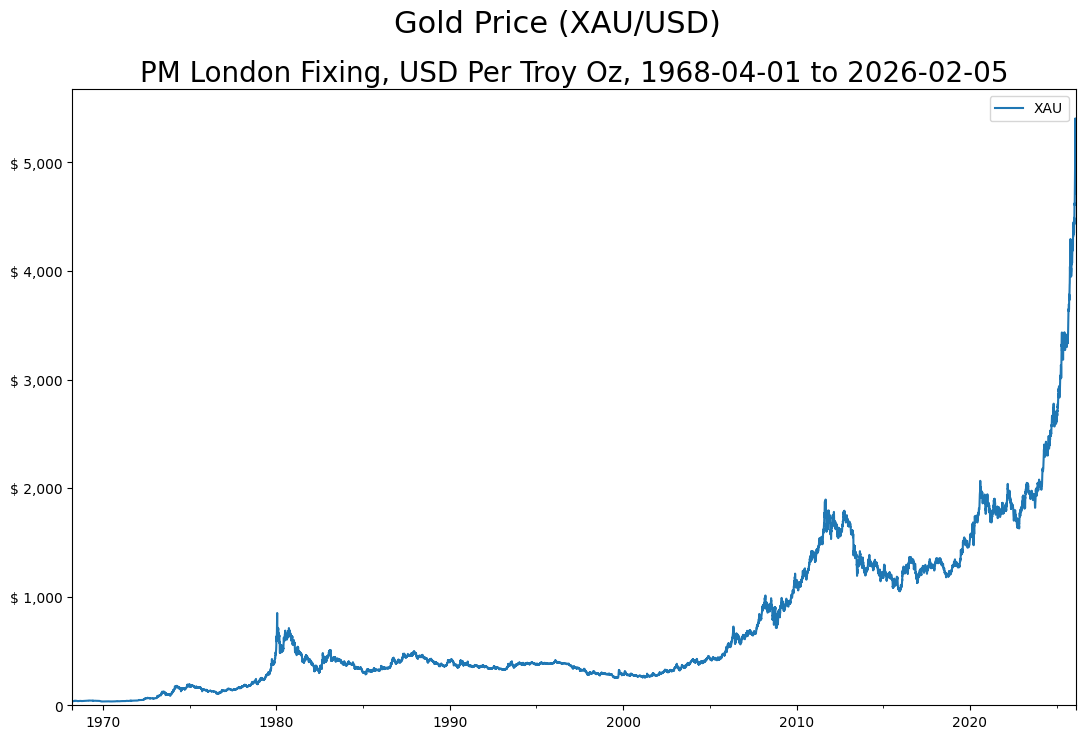

In [2]:
gold=pd.read_json(url:="https://prices.lbma.org.uk/json/gold_pm.json")[["d","v"]].set_index("d")
nprint("Read gold prices from %s." % url)
gold.index=pd.DatetimeIndex(gold.index).to_period('B')
gold.index.name='Date'
gold[('Close',alternative:='XAU')]=gold['v'].apply(lambda x:x[0])
gold.drop('v',axis=1,inplace=True)
gold.columns=pd.MultiIndex.from_tuples(gold.columns)
display(gold)

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
gold['Close'].plot(ax=plot)
figure.suptitle(title:='Gold Price (XAU/USD)',fontsize=22)
plot.set_title(subtitle:='PM London Fixing, USD Per Troy Oz, %s to %s' % (gold.index[0],gold.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.yaxis.set_major_formatter(CurrencyLabels(0))
plot.set_ylim(zero,None)
figure.savefig(title.replace("/","-")+".png",dpi=300,bbox_inches='tight')

You need to enter a FRED API key (your keys are stored here: https://fredaccount.stlouisfed.org/apikeys): ··········
14:04:51 Read Three Month Bills Rate from FRED.


/tmp/ipython-input-4154478611.py:9: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  bills.index=bills.index.to_timestamp().to_period('B')


,Discount Rate,Days,Return,Close
,DTB3,,,DTB3
Date,,,,
1954-01-04,1.33,0,NaN,1000.000000
1954-01-05,1.28,1,0.003694,1000.036944
1954-01-06,1.28,2,0.003556,1000.072501
1954-01-07,1.31,3,0.003556,1000.108059
1954-01-08,1.31,4,0.003639,1000.144452
...,...,...,...,...
2026-01-29,3.59,26323,0.009972,21484.978210
2026-01-30,3.58,26324,0.009972,21487.120740


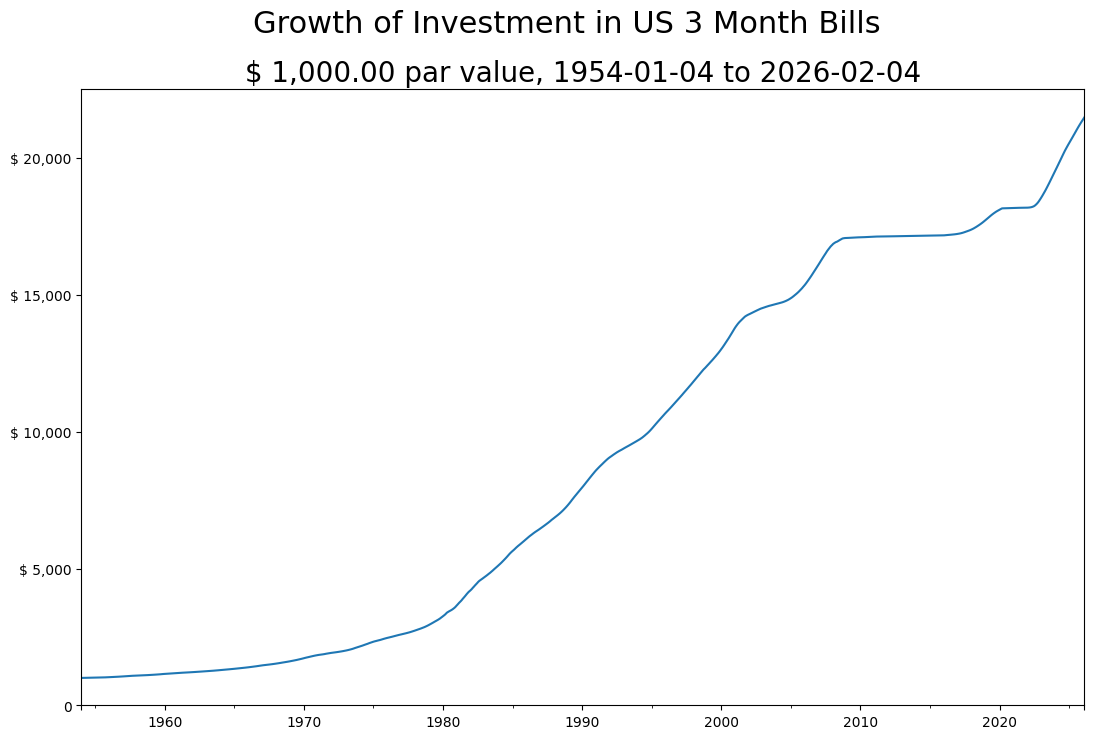

In [3]:
bills=get_fred(n:='DTB3')[0]
nprint("Read Three Month Bills Rate from FRED.")
bills.index.name='Date'
bills.columns=pd.MultiIndex.from_tuples([('Discount Rate',n)])
bills['Days']=list(map(lambda x:(x-bills.index[0]).n,bills.index))
bills['Return']=bills[('Discount Rate',n)].shift()/360e0*bills['Days'].diff()
bills[('Close',n)]=(par:=1e3)*(one+bills['Return']/hundred).cumprod()
bills.loc[bills.index[0],('Close',n)]=par
bills.index=bills.index.to_timestamp().to_period('B')
display(bills)

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
bills[('Close',n)].plot(ax=plot)
figure.suptitle(title:='Growth of Investment in US 3 Month Bills',fontsize=22)
plot.set_title(subtitle:='$ {:,.2f} par value, {:s} to {:s}'.format(par,str(bills.index[0]),str(bills.index[-1])),fontsize=20)
plot.set_xlabel(None)
plot.yaxis.set_major_formatter(CurrencyLabels(0))
plot.set_ylim(zero,None)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

[*********************100%***********************]  1 of 1 completed

14:46:45 Read ^GSPC data from Yahoo Finance.



/tmp/ipython-input-3712460329.py:4: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.DatetimeIndex(data.index).to_period('B')
/tmp/ipython-input-3712460329.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred


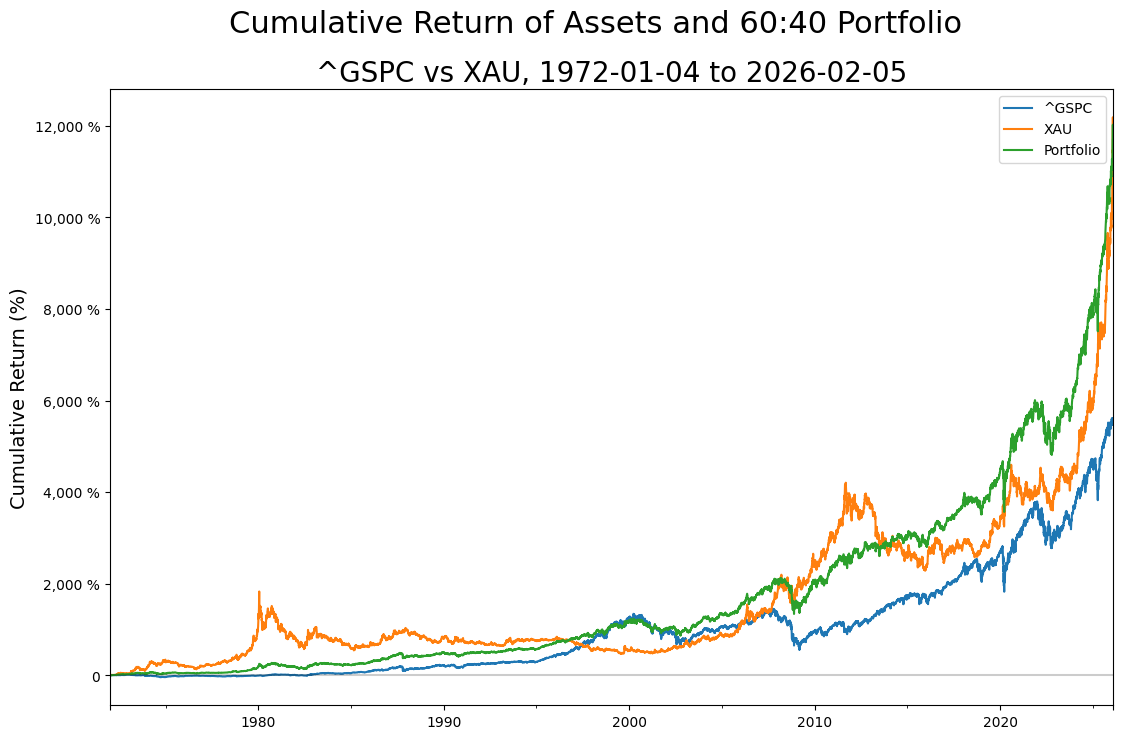

In [50]:
data=download(market:='^GSPC',"1972-01-01",today("%Y-%m-%d"),auto_adjust=True)
nprint("Read %s data from Yahoo Finance." % market)
tickers=[market,alternative:='XAU']
data.index=pd.DatetimeIndex(data.index).to_period('B')
data[('Close',alternative)]=gold[('Close',alternative)] if alternative=='XAU' else bills[('Close',alternative)]
data.columns=pd.MultiIndex.from_tuples(data.columns)
#data=data.resample('M').last()

for ticker in tickers:
    data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred
    data[('Weight',ticker)]=0.6 if ticker==market else 0.4

data.dropna(inplace=True)
data.sort_index(axis=1,inplace=True)
data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

for ticker in tickers+['Portfolio']:
    data[('Cumulative',ticker)]=(data[('Return',ticker)]/hundred+one).cumprod()*hundred-hundred

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and 60:40 Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [51]:
from warnings import filterwarnings ; filterwarnings('ignore',category=pd.errors.PerformanceWarning)

report=pd.DataFrame({'Weight':np.arange(zero,one+(delta:=0.025),delta)}).set_index("Weight")

if data.index.dtype==pd.PeriodDtype('W'):
    annualize=52e0

elif data.index.dtype==pd.PeriodDtype('M'):
    annualize=12e0

elif data.index.dtype==pd.PeriodDtype('Q'):
    annualize=4e0

elif data.index.dtype==pd.PeriodDtype('Y'):
    annualize=1e0

else:
    annualize=252e0

nprint("Finding optimal portfolio by brute-force scan.")

for weight in tqdm(report.index):
    report.loc[weight,market]=weight
    report.loc[weight,alternative]=one-weight

    for ticker in tickers:
        data[('Weight',ticker)]=report.loc[weight,ticker]

    data.drop(('Return','Portfolio'),axis=1,inplace=True)
    data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

    report.loc[weight,'Sample']=(r:=data[('Return','Portfolio')]).count()
    report.loc[weight,'Mean']=(m:=r.mean())
    report.loc[weight,'Std.Dev.']=(s:=r.std())
    report.loc[weight,'Std.Err.']=r.sem()
    report.loc[weight,'Kurtosis']=r.kurt()+three

report['Sharpe']=report['Mean']/report['Std.Dev.']*annualize**half
report['Sharpe S.E.']=((annualize/report['Sample'])*(one+(report['Kurtosis']-one)/four*report['Sharpe']**two))**half
report['Annualized']=hundred*(one+report['Mean']/hundred)**annualize-hundred

display(report)

14:46:52 Finding optimal portfolio by brute-force scan.


  0%|          | 0/41 [00:00<?, ?it/s]

,^GSPC,XAU,Sample,Mean,Std.Dev.,Std.Err.,Kurtosis,Sharpe,Sharpe S.E.,Annualized
Weight,,,,,,,,,,
0.000,0.000,1.000,13308.0,0.043211,1.256137,0.010889,13.316743,0.546081,0.190587,11.501535
0.025,0.025,0.975,13308.0,0.043036,1.224750,0.010617,13.328675,0.557808,0.192603,11.452387
0.050,0.050,0.950,13308.0,0.042861,1.194004,0.010350,13.328836,0.569844,0.194649,11.403260
0.075,0.075,0.925,13308.0,0.042686,1.163950,0.010090,13.315170,0.582171,0.196711,11.354155
0.100,0.100,0.900,13308.0,0.042511,1.134642,0.009836,13.285557,0.594759,0.198770,11.305071
0.125,0.125,0.875,13308.0,0.042336,1.106141,0.009589,13.237908,0.607572,0.200803,11.256009
0.150,0.150,0.850,13308.0,0.042161,1.078510,0.009349,13.170301,0.620562,0.202788,11.206969
0.175,0.175,0.825,13308.0,0.041986,1.051818,0.009118,13.081168,0.633668,0.204696,11.157950
0.200,0.200,0.800,13308.0,0.041811,1.026138,0.008895,12.969526,0.646818,0.206501,11.108952


In [52]:
s1,s12,s12,s2=data['Return'][tickers].cov().to_numpy().reshape(4)
w1=(s2**2-s12)/(s1**2+s2**2-two*s12)
w2=one-w1
nprint("Mean-Variance Optimal Fully Invested Portfolio is %.0f:%0.f." % (w1*hundred,w2*hundred))

14:50:30 Mean-Variance Optimal Fully Invested Portfolio is 63:37.


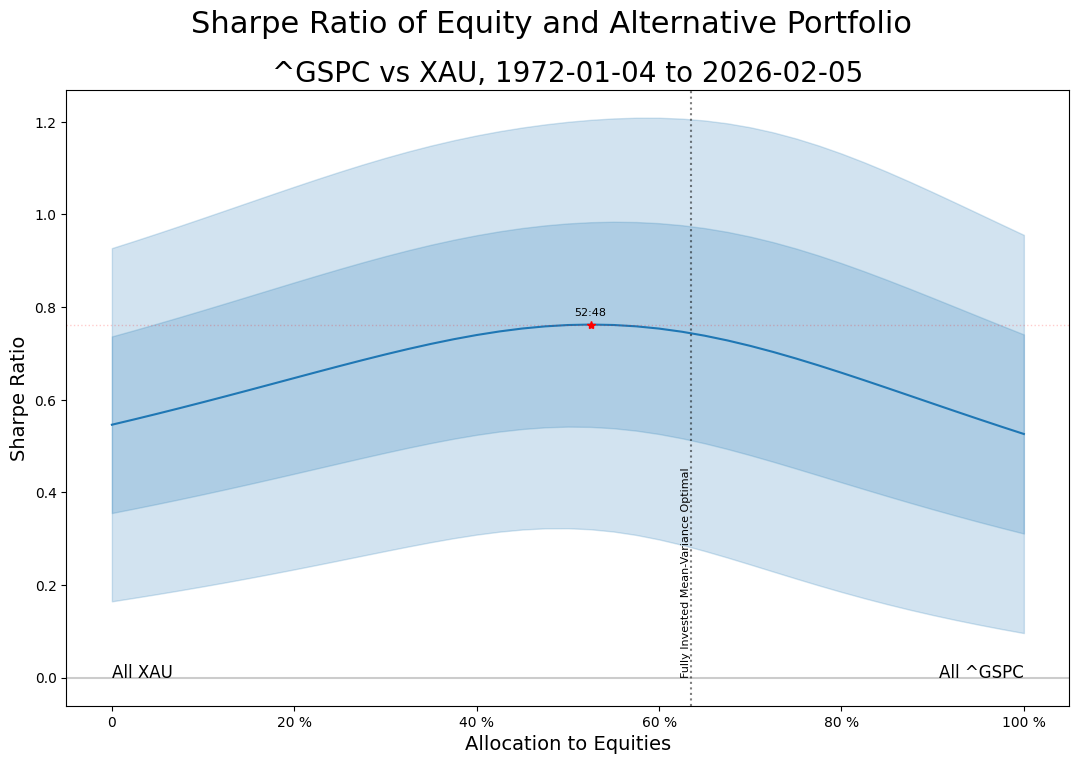

In [60]:
figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
plot.plot((x:=report.index.to_numpy())*hundred,y:=report.loc[x,'Sharpe'].to_numpy())
plot.fill_between(x*hundred,y+(ye:=report.loc[x,'Sharpe S.E.']),y-ye,color='C0',alpha=0.2)
plot.fill_between(x*hundred,y+two*ye,y-two*ye,color='C0',alpha=0.2)
figure.suptitle(title:='Sharpe Ratio of Equity and Alternative Portfolio',fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel('Allocation to Equities',fontsize=14)
plot.set_ylabel('Sharpe Ratio',fontsize=14)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.text(zero,zero,"All "+alternative,fontsize=12,horizontalalignment='left')
plot.text(hundred,zero,"All "+market,fontsize=12,horizontalalignment='right')
plot.axhline(color='black',alpha=0.2)
plot.plot(x[(omega:=y.argmax())]*hundred,y[omega],'r*')
plot.text(x[omega]*hundred,y[omega]*1.02,'%.0f:%.0f' % (x[omega]*hundred,hundred-x[omega]*hundred),fontsize=8,ha='center',va='bottom')
plot.axvline(w1*hundred,color='black',linestyle=':',alpha=0.5)
plot.axhline(y[omega],color='red',linestyle=':',linewidth=1,alpha=0.2)
plot.text(w1*hundred,zero,'Fully Invested Mean-Variance Optimal',rotation=90,ha='right',va='bottom',fontsize=8)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

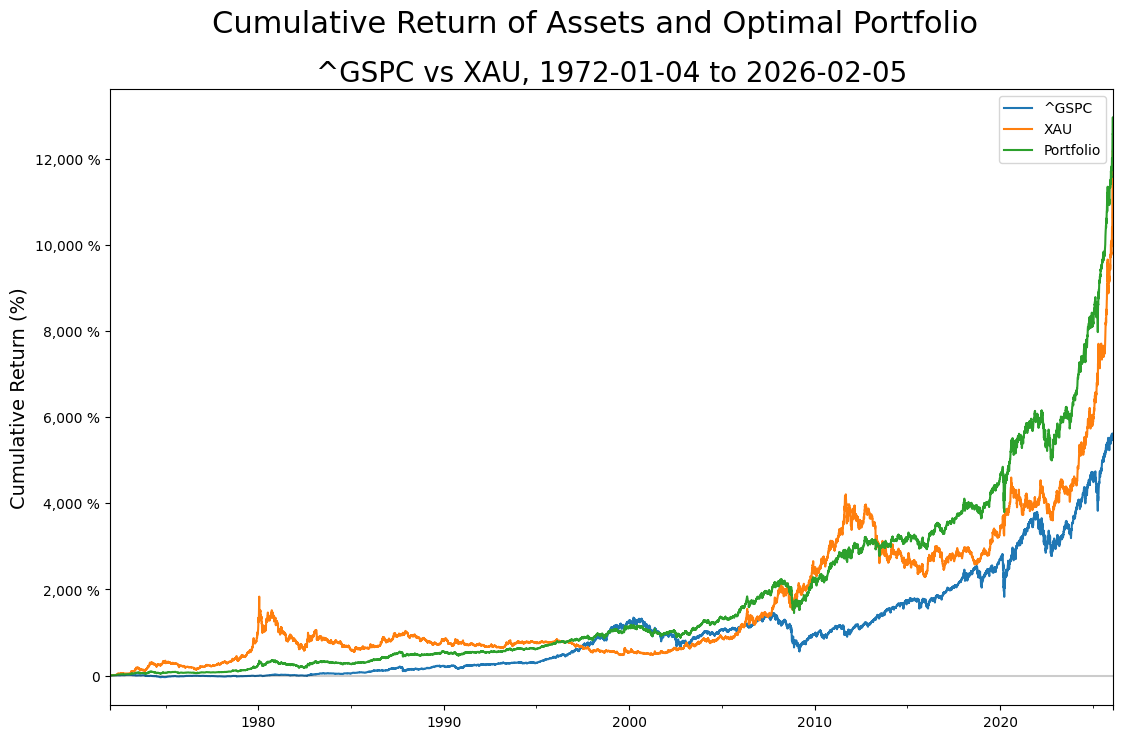

In [54]:
weight=x[omega]

for ticker in tickers:
    data[('Weight',ticker)]=report.loc[weight,ticker]

data.drop(('Return','Portfolio'),axis=1,inplace=True)
data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)
data[('Cumulative','Portfolio')]=(data[('Return','Portfolio')]/hundred+one).cumprod()*hundred-hundred

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and Optimal Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

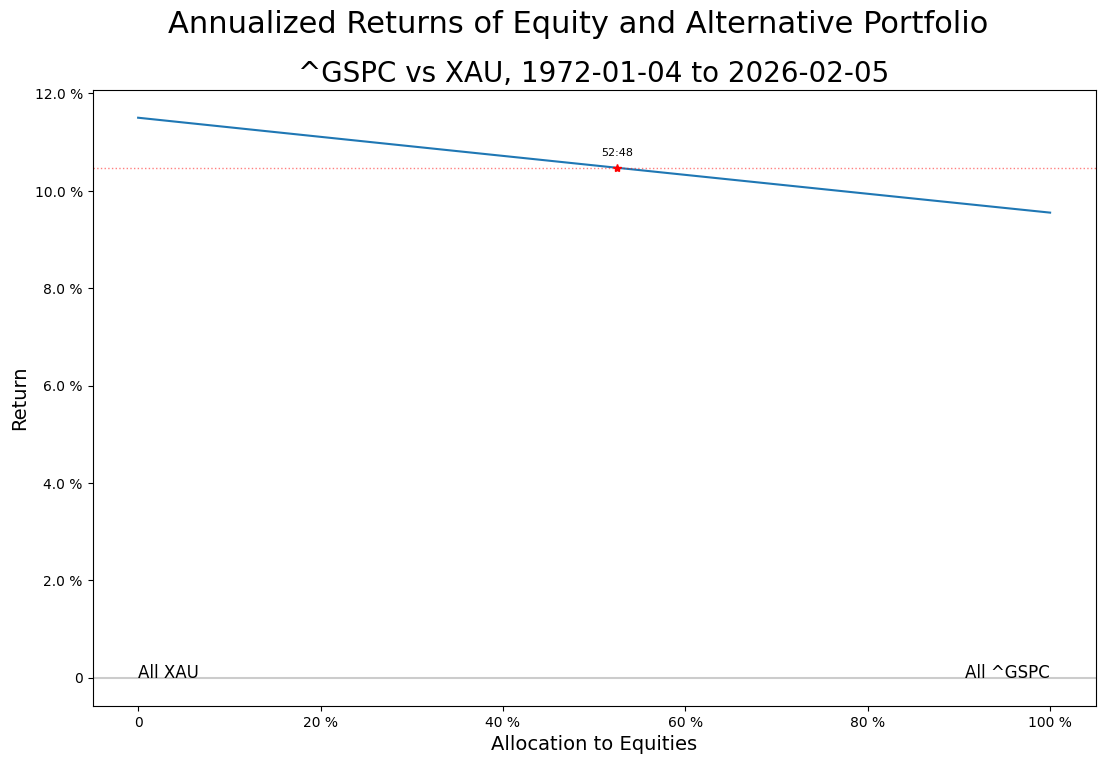

In [55]:
figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
plot.plot((x:=report.index.to_numpy())*hundred,y:=report.loc[x,'Annualized'].to_numpy())
figure.suptitle(title:='Annualized Returns of Equity and Alternative Portfolio',fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel('Allocation to Equities',fontsize=14)
plot.set_ylabel('Return',fontsize=14)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.yaxis.set_major_formatter(PercentLabels(1))
plot.text(zero,zero,"All "+alternative,fontsize=12,horizontalalignment='left')
plot.text(hundred,zero,"All "+market,fontsize=12,horizontalalignment='right')
plot.axhline(color='black',alpha=0.2)
plot.plot(x[omega]*hundred,y[omega],'r*')
plot.text(x[omega]*hundred,y[omega]*1.02,'%.0f:%.0f' % (x[omega]*hundred,hundred-x[omega]*hundred),fontsize=8,ha='center',va='bottom')
plot.axhline(y[omega],color='red',linestyle=':',linewidth=1,alpha=0.5)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')